In [1]:
# %load loadTracks.py
'''

    This script helps to understand the track format used in proPTV.
    Generally, the output format of all tracks is a .hdf5 file. 
    Each entry of the .hdf5 file is a track stored as a single numpy array with dimensions:
            
        track.shape = (len(track),10+2*len(cams))
        
        In our case len(cams) = 4, the number of cams=[0,1,2,3] and the number of rows of each track is 18. They are:
            
            t, X, Y, Z, VX, VY, VZ, AX, AY, AZ, x_c0, x_c0 ,y_c0, x_c1, y_c1, x_c2, y_c2, x_c3, y_c3
            (time of frame, 3D-X position, 3D-Y position, 3D-Z position, 
             3D-X velocity, 3D-Y velocity, 3D-Z velocity, 
             3D-X acceleration, 3D-Y acceleration, 3D-Z acceleration,
             x reprojection position on cam 0, y reprojection position on cam 0,
             x reprojection position on cam 1, y reprojection position on cam 1,
             x reprojection position on cam 2, y reprojection position on cam 2,
             x reprojection position on cam 3, y reprojection position on cam 3)
    
    When loaded in python, all tracks are stored in a list named "allTracks". 
    Each track in allTracks is also a list containing the following informations
    
        track = [time,pos,vel,acc,xy]
    
    time ... list of numbers of the corresponding frame, e.g. [0, 1, 2, ..., 49]
    pos ... list of numpy arrays [np.array([X0,Y0,Z0]), np.array([X1,Y1,Z1]), ...] containing the 3D position per time step where the track is active.
    vel ... same as pos but the arrays store VX, VY, VZ, i.e. the displacement velocity in your physical space unit
    acc ... same as pos but the arrays store AX, AY, AZ, i.e. the displacement acceleration in your physical space unit
    xy ... is a list of numpy arrays containing the x and y reprojection position on the image for each camera, e.g.
            xy = [xy0,xy1,xy2,...] with xy0 = np.array([x_c0,y_c0,x_c1,y_c1,x_c2,y_c2,x_c3,y_c3]) if one considers 4 cams c0, c1, c2, c3
            the points xy are the projection of the 3D points pos into the different cameras.
    
'''


import h5py
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize

In [2]:
def LoadTracks():
    # load tracks from hdf5 file
    data = h5py.File("tracks.hdf5", "r")
    tracks = [data[key][:] for key in tqdm(list(data.keys()),desc='Loading tracks: ',leave=True,position=0,delay=0.5)]
    data.close()
    # transform the data format to allTracks in the list format which is used during the code execution
    allTracks = []
    for track in tracks:
        time, pos, vel, acc, xy = list(track[:,0]), list(track[:,1:4:]), list(track[:,4:7:]), list(track[:,7:10]), list(track[:,10:])
        allTracks.append([time, pos, vel, acc, xy])
    return allTracks

In [3]:
def PlotTracks(allTracks,maxvel):
    # plot tracks
    fig = plt.figure(figsize=(8,8))
    axis = fig.add_subplot(111, projection='3d')
    for track in tqdm(allTracks, desc='Plot tracks', position=0 , leave=True, delay=0.5):
        # for each track get the positions
        pos = np.asarray(track[1])
        x, y, z = pos[:,0], pos[:,1], pos[:,2]
        # load the velocitiy of the track and select the color as the vz velocity
        vel = np.asarray(track[2])
        color = vel[:,2]
        colorNorm = Normalize(-maxvel,maxvel)
        # define line segment
        points = np.array([x,y,z]).transpose().reshape(-1,1,3)
        segs = np.concatenate([points[:-1],points[1:]],axis=1)
        lc = Line3DCollection(segs,cmap='seismic',norm=colorNorm,linewidths=0.4,alpha=1)
        lc.set_array(color) 
        # add the line segment to the figure
        axis.add_collection3d(lc)
    axis.set_title('number of tracks: ' + str(len(allTracks)))
    axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
    plt.tight_layout(), plt.show()
    # save tracks
    plt.savefig('allTracks.png',dpi=200)
    

In [4]:
def SaveTracks(allTracks,length_cams):
    # save allTracks list as hdf5 file
    saveFile = h5py.File("tracks_saved.hdf5", 'w')
    for key, track in enumerate(tqdm(allTracks, desc='Save tracks: ', position=0, leave=True, delay=0.5)):
        # convert the each track into a single numpy array called datas
        time = np.array(track[0]).reshape(len(track[0]),1)
        pos = np.array(track[1]).reshape(len(track[1]),3)
        vel = np.array(track[2]).reshape(len(track[2]),3)
        acc = np.array(track[3]).reshape(len(track[3]),3)
        xy = np.ravel(track[4]).reshape(len(track[4]),int(2*length_cams))
        datas = np.hstack([time,pos,vel,acc,xy])
        saveFile.create_dataset("track_"+str(key), datas.shape, dtype='float64', data=datas)
    saveFile.close()
    

Plot tracks: 100%|████████████████████████| 7311/7311 [00:02<00:00, 3044.64it/s]


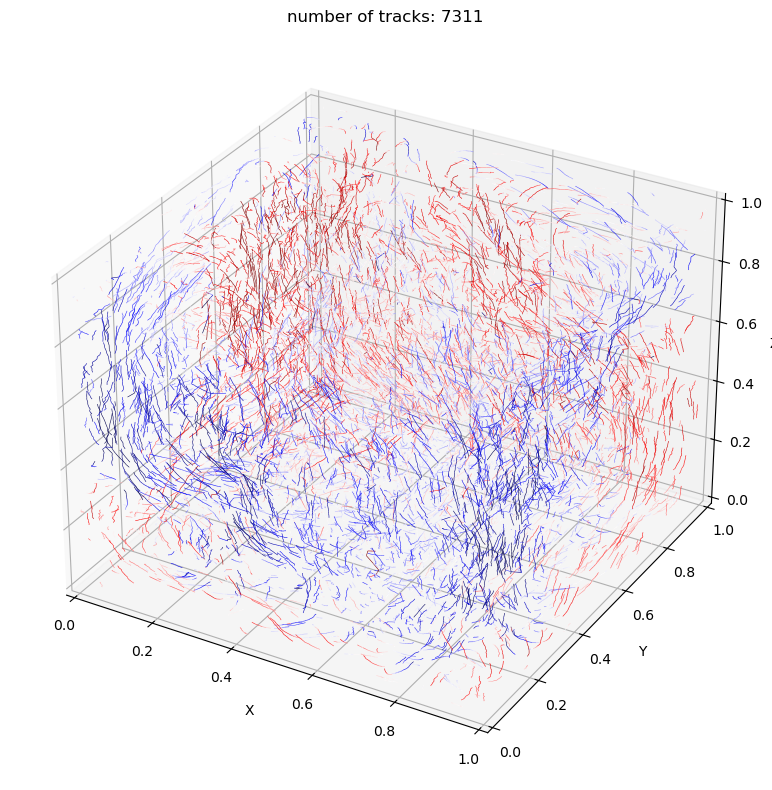

Save tracks: 100%|████████████████████████| 7311/7311 [00:01<00:00, 5247.76it/s]


<Figure size 640x480 with 0 Axes>

In [5]:
def main():
    # load tracks
    allTracks = LoadTracks()
    # plot tracks
    maxvel = 0.01
    PlotTracks(allTracks,maxvel)
    # save tracks
    cams = [0,1,2,3]
    length_cams = len(cams)
    SaveTracks(allTracks,length_cams)

# if __name__ == "__main__":
main()